In [3]:
!export CUDA_VISIBLE_DEVICES=0

%cd /data/codes/apa/train/
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

import pickle
import json
import re
import os

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch

from src.utils.train import (
    load_data,
    to_device,
    validate
)

from src.dataset import PrepDataset
from src.model import PrepModel

/data/codes/apa/train


In [4]:
ckpt_dir = '/data/codes/apa/train/exp/pre-training'
train_dir = "/data/codes/apa/train/data/feats/train/train-data-type-10-filtered/"
test_dir = "/data/codes/apa/train/data/feats/train/train-data-type-12-filtered/"

max_length=128
relative2id_path="/data/codes/apa/train/exp/dicts/relative2id.json"
phone2id_path="/data/codes/apa/train/exp/dicts/phone_dict.json"

ids, phone_ids_path, word_ids_path, \
    phone_scores_path, word_scores_path, sentence_scores_path, fluency_score_path, intonation_score_path, \
    durations_path, gops_path, relative_positions_path, wavlm_features_path = load_data(train_dir)

trainset = PrepDataset(
    ids=ids, 
    phone_ids_path=phone_ids_path, 
    word_ids_path=word_ids_path, 
    phone_scores_path=phone_scores_path, 
    word_scores_path=word_scores_path, 
    sentence_scores_path=sentence_scores_path, 
    fluency_score_path=sentence_scores_path,
    intonation_scores_path=sentence_scores_path,
    durations_path=durations_path, 
    gops_path=gops_path, 
    relative_positions_path=relative_positions_path, 
    wavlm_features_path=wavlm_features_path,
    relative2id_path=relative2id_path, 
    phone2id_path=phone2id_path,
    max_length=max_length
)

trainloader = DataLoader(
    trainset, 
    batch_size=8, 
    num_workers=1,
    shuffle=True, 
    drop_last=False, 
    pin_memory=True
)

ids, phone_ids_path, word_ids_path, \
    phone_scores_path, word_scores_path, sentence_scores_path, fluency_score_path, intonation_score_path, \
    durations_path, gops_path, relative_positions_path, wavlm_features_path = load_data(test_dir)

testset = PrepDataset(
    ids=ids, 
    phone_ids_path=phone_ids_path, 
    word_ids_path=word_ids_path, 
    phone_scores_path=phone_scores_path, 
    word_scores_path=word_scores_path, 
    sentence_scores_path=sentence_scores_path, 
    fluency_score_path=sentence_scores_path,
    intonation_scores_path=sentence_scores_path,
    durations_path=durations_path, 
    gops_path=gops_path, 
    relative_positions_path=relative_positions_path, 
    wavlm_features_path=wavlm_features_path,
    relative2id_path=relative2id_path, 
    phone2id_path=phone2id_path,
    max_length=max_length
)

testloader = DataLoader(
    testset, 
    num_workers=1,
    batch_size=64, 
    shuffle=False, 
    drop_last=True, 
)

In [5]:
embed_dim=32
num_heads=1
depth=3
input_dim=855
num_phone=44
max_length=256
dropout=0.1

lr=1e-3
weight_decay=5e-7
betas=(0.95, 0.999)

device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu")

gopt_model = PrepModel(
    embed_dim=embed_dim, 
    num_heads=num_heads, 
    depth=depth, 
    input_dim=input_dim, 
    max_length=max_length, 
    num_phone=num_phone, 
    dropout=dropout).to(device)

trainables = [p for p in gopt_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(
    trainables, lr, 
    weight_decay=weight_decay, 
    betas=betas
)

loss_fn = nn.MSELoss()

In [6]:
def calculate_losses(
        phone_preds, phone_labels, 
        word_preds, word_labels, 
        utterance_preds, utterance_labels, 
        fluency_preds=None, fluency_labels=None,
        intonation_preds=None, intonation_labels=None):
    
    # phone level
    mask = phone_labels >=0
    phone_preds = phone_preds.squeeze(2) * mask
    phone_labels = phone_labels * mask
    
    loss_phn = loss_fn(phone_preds, phone_labels)
    loss_phn = loss_phn * (mask.shape[0] * mask.shape[1]) / torch.sum(mask)

    # utterance level
    loss_utt = loss_fn(utterance_preds.squeeze(1), utterance_labels)

    if (fluency_preds is None) or (fluency_labels is None) or (intonation_preds is None) or (intonation_labels is None):
        loss_utt_flu = 0
        loss_utt_int = 0
    else:
        loss_utt_flu = loss_fn(fluency_preds.squeeze(1), fluency_labels)
        loss_utt_int = loss_fn(intonation_preds.squeeze(1), intonation_labels)

    # word level
    mask = word_labels >= 0      
    word_preds = word_preds.squeeze(2) * mask
    word_labels = word_labels * mask
    
    loss_word = loss_fn(word_preds, word_labels)
    loss_word = loss_word * (mask.shape[0] * mask.shape[1]) / torch.sum(mask)

    return loss_phn, loss_utt, loss_word, loss_utt_flu, loss_utt_int

Training: 100%|██████████| 11947/11947 [01:04<00:00, 184.78it/s, loss=0.567, loss_phn=0.449, loss_utt=0.0535, loss_word=0.0665, lr=0.001]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.84      0.90    199927
         1.0       0.16      0.52      0.25     14599
         2.0       0.78      0.62      0.69     31139

    accuracy                           0.79    245665
   macro avg       0.64      0.66      0.61    245665
weighted avg       0.89      0.79      0.83    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=0-mse=0.148499995470047
### Validation result (epoch=0)
  Phone level (ACC): MSE=0.148  MAE=0.231  PCC=0.792 
   Word level (ACC): MSE=0.069  MAE=0.194  PCC=0.747 
    Utt level (ACC): MSE=0.048  MAE=0.167  PCC=0.797 
    Utt level (Intonation):  MSE=0.048  MAE=0.167  PCC=0.798
    Utt level (Fluency):  MSE=0.049  MAE=0.169  PCC=0.796



Training: 100%|██████████| 11947/11947 [01:04<00:00, 185.78it/s, loss=0.00401, loss_phn=0.0029, loss_utt=0.00127, loss_word=0.000181, lr=0.001]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.91      0.94    199927
         1.0       0.21      0.52      0.30     14599
         2.0       0.86      0.56      0.68     31139

    accuracy                           0.84    245665
   macro avg       0.68      0.66      0.64    245665
weighted avg       0.90      0.84      0.87    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=1-mse=0.11620000004768372
### Validation result (epoch=1)
  Phone level (ACC): MSE=0.116  MAE=0.187  PCC=0.838 
   Word level (ACC): MSE=0.053  MAE=0.166  PCC=0.805 
    Utt level (ACC): MSE=0.034  MAE=0.131  PCC=0.847 
    Utt level (Intonation):  MSE=0.034  MAE=0.132  PCC=0.847
    Utt level (Fluency):  MSE=0.034  MAE=0.132  PCC=0.845



Training: 100%|██████████| 11947/11947 [01:04<00:00, 184.60it/s, loss=0.0525, loss_phn=0.0287, loss_utt=0.0106, loss_word=0.0125, lr=0.001]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.89      0.93    199927
         1.0       0.20      0.52      0.29     14599
         2.0       0.83      0.65      0.73     31139

    accuracy                           0.84    245665
   macro avg       0.67      0.69      0.65    245665
weighted avg       0.90      0.84      0.86    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=2-mse=0.11330000311136246
### Validation result (epoch=2)
  Phone level (ACC): MSE=0.113  MAE=0.194  PCC=0.842 
   Word level (ACC): MSE=0.064  MAE=0.178  PCC=0.799 
    Utt level (ACC): MSE=0.045  MAE=0.150  PCC=0.850 
    Utt level (Intonation):  MSE=0.042  MAE=0.145  PCC=0.851
    Utt level (Fluency):  MSE=0.045  MAE=0.150  PCC=0.850



Training: 100%|██████████| 11947/11947 [01:04<00:00, 183.97it/s, loss=0.75, loss_phn=0.365, loss_utt=0.212, loss_word=0.178, lr=0.001]      


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.88      0.93    199927
         1.0       0.21      0.51      0.29     14599
         2.0       0.82      0.71      0.76     31139

    accuracy                           0.84    245665
   macro avg       0.67      0.70      0.66    245665
weighted avg       0.91      0.84      0.87    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=3-mse=0.10490000247955322
### Validation result (epoch=3)
  Phone level (ACC): MSE=0.105  MAE=0.181  PCC=0.855 
   Word level (ACC): MSE=0.055  MAE=0.172  PCC=0.815 
    Utt level (ACC): MSE=0.032  MAE=0.132  PCC=0.868 
    Utt level (Intonation):  MSE=0.033  MAE=0.136  PCC=0.867
    Utt level (Fluency):  MSE=0.033  MAE=0.133  PCC=0.868



Training: 100%|██████████| 11947/11947 [01:04<00:00, 184.54it/s, loss=0.0763, loss_phn=0.076, loss_utt=3.11e-7, loss_word=0.000243, lr=0.001]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.98      0.84      0.90    199927
         1.0       0.18      0.57      0.27     14599
         2.0       0.80      0.74      0.77     31139

    accuracy                           0.81    245665
   macro avg       0.66      0.72      0.65    245665
weighted avg       0.91      0.81      0.85    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=4-mse=0.11180000007152557
### Validation result (epoch=4)
  Phone level (ACC): MSE=0.112  MAE=0.219  PCC=0.859 
   Word level (ACC): MSE=0.060  MAE=0.191  PCC=0.830 
    Utt level (ACC): MSE=0.047  MAE=0.172  PCC=0.863 
    Utt level (Intonation):  MSE=0.045  MAE=0.168  PCC=0.863
    Utt level (Fluency):  MSE=0.046  MAE=0.169  PCC=0.863



Training: 100%|██████████| 11947/11947 [01:04<00:00, 184.68it/s, loss=0.457, loss_phn=0.403, loss_utt=0.02, loss_word=0.0334, lr=0.001]      


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.87      0.92    199927
         1.0       0.19      0.53      0.28     14599
         2.0       0.82      0.68      0.74     31139

    accuracy                           0.83    245665
   macro avg       0.66      0.69      0.65    245665
weighted avg       0.91      0.83      0.86    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=5-mse=0.11230000108480453
### Validation result (epoch=5)
  Phone level (ACC): MSE=0.112  MAE=0.191  PCC=0.844 
   Word level (ACC): MSE=0.057  MAE=0.175  PCC=0.819 
    Utt level (ACC): MSE=0.041  MAE=0.148  PCC=0.845 
    Utt level (Intonation):  MSE=0.042  MAE=0.152  PCC=0.845
    Utt level (Fluency):  MSE=0.042  MAE=0.152  PCC=0.845



Training: 100%|██████████| 11947/11947 [01:06<00:00, 180.90it/s, loss=0.00904, loss_phn=0.00612, loss_utt=0.00204, loss_word=0.0011, lr=0.001]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.98      0.88      0.92    199927
         1.0       0.20      0.54      0.30     14599
         2.0       0.82      0.72      0.77     31139

    accuracy                           0.84    245665
   macro avg       0.67      0.71      0.66    245665
weighted avg       0.91      0.84      0.87    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=6-mse=0.1005999967455864
### Validation result (epoch=6)
  Phone level (ACC): MSE=0.101  MAE=0.179  PCC=0.862 
   Word level (ACC): MSE=0.052  MAE=0.165  PCC=0.840 
    Utt level (ACC): MSE=0.039  MAE=0.145  PCC=0.867 
    Utt level (Intonation):  MSE=0.038  MAE=0.143  PCC=0.867
    Utt level (Fluency):  MSE=0.039  MAE=0.144  PCC=0.867



Training: 100%|██████████| 11947/11947 [01:05<00:00, 181.33it/s, loss=0.0679, loss_phn=0.041, loss_utt=0.00938, loss_word=0.0177, lr=0.001]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.98      0.88      0.93    199927
         1.0       0.21      0.56      0.31     14599
         2.0       0.84      0.71      0.77     31139

    accuracy                           0.84    245665
   macro avg       0.68      0.72      0.67    245665
weighted avg       0.91      0.84      0.87    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=7-mse=0.09589999914169312
### Validation result (epoch=7)
  Phone level (ACC): MSE=0.096  MAE=0.184  PCC=0.870 
   Word level (ACC): MSE=0.051  MAE=0.168  PCC=0.839 
    Utt level (ACC): MSE=0.032  MAE=0.136  PCC=0.875 
    Utt level (Intonation):  MSE=0.032  MAE=0.135  PCC=0.875
    Utt level (Fluency):  MSE=0.032  MAE=0.134  PCC=0.875



Training: 100%|██████████| 11947/11947 [01:06<00:00, 179.01it/s, loss=0.189, loss_phn=0.112, loss_utt=0.0432, loss_word=0.0349, lr=0.001]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.23      0.52      0.32     14599
         2.0       0.85      0.70      0.76     31139

    accuracy                           0.86    245665
   macro avg       0.68      0.71      0.67    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=8-mse=0.09269999712705612
### Validation result (epoch=8)
  Phone level (ACC): MSE=0.093  MAE=0.165  PCC=0.872 
   Word level (ACC): MSE=0.044  MAE=0.144  PCC=0.844 
    Utt level (ACC): MSE=0.026  MAE=0.114  PCC=0.891 
    Utt level (Intonation):  MSE=0.026  MAE=0.113  PCC=0.891
    Utt level (Fluency):  MSE=0.026  MAE=0.114  PCC=0.892



Training: 100%|██████████| 11947/11947 [01:08<00:00, 174.90it/s, loss=0.0255, loss_phn=0.0248, loss_utt=9.75e-5, loss_word=0.00058, lr=0.001]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94    199927
         1.0       0.23      0.51      0.32     14599
         2.0       0.83      0.72      0.78     31139

    accuracy                           0.86    245665
   macro avg       0.68      0.71      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=9-mse=0.0934000015258789
### Validation result (epoch=9)
  Phone level (ACC): MSE=0.093  MAE=0.165  PCC=0.871 
   Word level (ACC): MSE=0.044  MAE=0.143  PCC=0.845 
    Utt level (ACC): MSE=0.028  MAE=0.117  PCC=0.879 
    Utt level (Intonation):  MSE=0.028  MAE=0.116  PCC=0.879
    Utt level (Fluency):  MSE=0.028  MAE=0.117  PCC=0.880



Training: 100%|██████████| 11947/11947 [01:11<00:00, 168.02it/s, loss=0.0406, loss_phn=0.0232, loss_utt=0.00846, loss_word=0.00875, lr=0.001]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    199927
         1.0       0.20      0.52      0.29     14599
         2.0       0.81      0.76      0.78     31139

    accuracy                           0.84    245665
   macro avg       0.66      0.72      0.66    245665
weighted avg       0.91      0.84      0.87    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=10-mse=0.1006999984383583
### Validation result (epoch=10)
  Phone level (ACC): MSE=0.101  MAE=0.178  PCC=0.864 
   Word level (ACC): MSE=0.057  MAE=0.178  PCC=0.838 
    Utt level (ACC): MSE=0.047  MAE=0.159  PCC=0.858 
    Utt level (Intonation):  MSE=0.047  MAE=0.161  PCC=0.858
    Utt level (Fluency):  MSE=0.047  MAE=0.160  PCC=0.858



Training: 100%|██████████| 11947/11947 [01:13<00:00, 163.26it/s, loss=0.035, loss_phn=0.00241, loss_utt=0.0174, loss_word=0.0135, lr=0.001]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94    199927
         1.0       0.23      0.55      0.32     14599
         2.0       0.85      0.71      0.77     31139

    accuracy                           0.86    245665
   macro avg       0.68      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=11-mse=0.09070000052452087
### Validation result (epoch=11)
  Phone level (ACC): MSE=0.091  MAE=0.165  PCC=0.875 
   Word level (ACC): MSE=0.043  MAE=0.147  PCC=0.854 
    Utt level (ACC): MSE=0.028  MAE=0.122  PCC=0.886 
    Utt level (Intonation):  MSE=0.028  MAE=0.121  PCC=0.887
    Utt level (Fluency):  MSE=0.028  MAE=0.121  PCC=0.887



Training: 100%|██████████| 11947/11947 [01:15<00:00, 159.20it/s, loss=0.032, loss_phn=0.0129, loss_utt=0.0112, loss_word=0.00805, lr=0.0008]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.55      0.33     14599
         2.0       0.86      0.69      0.76     31139

    accuracy                           0.86    245665
   macro avg       0.69      0.71      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=12-mse=0.08950000256299973
### Validation result (epoch=12)
  Phone level (ACC): MSE=0.089  MAE=0.163  PCC=0.876 
   Word level (ACC): MSE=0.041  MAE=0.146  PCC=0.857 
    Utt level (ACC): MSE=0.028  MAE=0.122  PCC=0.876 
    Utt level (Intonation):  MSE=0.028  MAE=0.122  PCC=0.876
    Utt level (Fluency):  MSE=0.028  MAE=0.122  PCC=0.876



Training: 100%|██████████| 11947/11947 [01:12<00:00, 164.86it/s, loss=0.119, loss_phn=0.093, loss_utt=0.0111, loss_word=0.0159, lr=0.0008]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.89      0.93    199927
         1.0       0.22      0.52      0.31     14599
         2.0       0.83      0.75      0.79     31139

    accuracy                           0.85    245665
   macro avg       0.67      0.72      0.68    245665
weighted avg       0.91      0.85      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=13-mse=0.09120000153779984
### Validation result (epoch=13)
  Phone level (ACC): MSE=0.091  MAE=0.170  PCC=0.877 
   Word level (ACC): MSE=0.046  MAE=0.153  PCC=0.854 
    Utt level (ACC): MSE=0.033  MAE=0.129  PCC=0.879 
    Utt level (Intonation):  MSE=0.032  MAE=0.129  PCC=0.880
    Utt level (Fluency):  MSE=0.032  MAE=0.128  PCC=0.880



Training: 100%|██████████| 11947/11947 [01:12<00:00, 164.10it/s, loss=0.24, loss_phn=0.137, loss_utt=0.052, loss_word=0.0513, lr=0.0008]      


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95    199927
         1.0       0.25      0.52      0.34     14599
         2.0       0.87      0.66      0.75     31139

    accuracy                           0.87    245665
   macro avg       0.70      0.70      0.68    245665
weighted avg       0.91      0.87      0.89    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=14-mse=0.08990000188350677
### Validation result (epoch=14)
  Phone level (ACC): MSE=0.090  MAE=0.161  PCC=0.876 
   Word level (ACC): MSE=0.042  MAE=0.142  PCC=0.852 
    Utt level (ACC): MSE=0.026  MAE=0.116  PCC=0.884 
    Utt level (Intonation):  MSE=0.026  MAE=0.116  PCC=0.885
    Utt level (Fluency):  MSE=0.026  MAE=0.116  PCC=0.885



Training: 100%|██████████| 11947/11947 [01:14<00:00, 161.41it/s, loss=0.377, loss_phn=0.235, loss_utt=0.0718, loss_word=0.0676, lr=0.00064]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.98      0.88      0.93    199927
         1.0       0.22      0.54      0.31     14599
         2.0       0.82      0.74      0.78     31139

    accuracy                           0.84    245665
   macro avg       0.67      0.72      0.67    245665
weighted avg       0.91      0.84      0.87    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=15-mse=0.09459999948740005
### Validation result (epoch=15)
  Phone level (ACC): MSE=0.095  MAE=0.189  PCC=0.875 
   Word level (ACC): MSE=0.051  MAE=0.168  PCC=0.853 
    Utt level (ACC): MSE=0.035  MAE=0.139  PCC=0.879 
    Utt level (Intonation):  MSE=0.036  MAE=0.143  PCC=0.879
    Utt level (Fluency):  MSE=0.035  MAE=0.140  PCC=0.879



Training: 100%|██████████| 11947/11947 [01:12<00:00, 164.51it/s, loss=0.185, loss_phn=0.102, loss_utt=0.0371, loss_word=0.0464, lr=0.00064]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94    199927
         1.0       0.23      0.53      0.32     14599
         2.0       0.84      0.74      0.78     31139

    accuracy                           0.86    245665
   macro avg       0.68      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=16-mse=0.08839999884366989
### Validation result (epoch=16)
  Phone level (ACC): MSE=0.088  MAE=0.163  PCC=0.878 
   Word level (ACC): MSE=0.042  MAE=0.140  PCC=0.855 
    Utt level (ACC): MSE=0.026  MAE=0.118  PCC=0.889 
    Utt level (Intonation):  MSE=0.026  MAE=0.118  PCC=0.889
    Utt level (Fluency):  MSE=0.026  MAE=0.118  PCC=0.889



Training: 100%|██████████| 11947/11947 [01:13<00:00, 162.23it/s, loss=0.291, loss_phn=0.289, loss_utt=0.00137, loss_word=0.000541, lr=0.00064] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.23      0.51      0.32     14599
         2.0       0.83      0.74      0.78     31139

    accuracy                           0.86    245665
   macro avg       0.68      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=17-mse=0.0892999991774559
### Validation result (epoch=17)
  Phone level (ACC): MSE=0.089  MAE=0.162  PCC=0.878 
   Word level (ACC): MSE=0.042  MAE=0.143  PCC=0.855 
    Utt level (ACC): MSE=0.028  MAE=0.122  PCC=0.888 
    Utt level (Intonation):  MSE=0.028  MAE=0.122  PCC=0.888
    Utt level (Fluency):  MSE=0.028  MAE=0.122  PCC=0.888



Training: 100%|██████████| 11947/11947 [01:15<00:00, 159.29it/s, loss=0.224, loss_phn=0.092, loss_utt=0.0614, loss_word=0.0696, lr=0.000512]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.92      0.94    199927
         1.0       0.24      0.51      0.33     14599
         2.0       0.85      0.72      0.78     31139

    accuracy                           0.87    245665
   macro avg       0.69      0.72      0.68    245665
weighted avg       0.91      0.87      0.89    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=18-mse=0.08669999986886978
### Validation result (epoch=18)
  Phone level (ACC): MSE=0.087  MAE=0.157  PCC=0.881 
   Word level (ACC): MSE=0.041  MAE=0.145  PCC=0.860 
    Utt level (ACC): MSE=0.027  MAE=0.120  PCC=0.889 
    Utt level (Intonation):  MSE=0.027  MAE=0.120  PCC=0.889
    Utt level (Fluency):  MSE=0.027  MAE=0.120  PCC=0.889



Training: 100%|██████████| 11947/11947 [01:13<00:00, 161.70it/s, loss=0.254, loss_phn=0.0529, loss_utt=0.0866, loss_word=0.113, lr=0.000512]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.93    199927
         1.0       0.23      0.51      0.31     14599
         2.0       0.82      0.75      0.78     31139

    accuracy                           0.86    245665
   macro avg       0.67      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=19-mse=0.09130000323057175
### Validation result (epoch=19)
  Phone level (ACC): MSE=0.091  MAE=0.171  PCC=0.876 
   Word level (ACC): MSE=0.044  MAE=0.146  PCC=0.855 
    Utt level (ACC): MSE=0.029  MAE=0.125  PCC=0.885 
    Utt level (Intonation):  MSE=0.029  MAE=0.125  PCC=0.886
    Utt level (Fluency):  MSE=0.029  MAE=0.125  PCC=0.886



Training: 100%|██████████| 11947/11947 [01:13<00:00, 163.01it/s, loss=0.0464, loss_phn=0.0335, loss_utt=0.00615, loss_word=0.00631, lr=0.000512]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.92      0.95    199927
         1.0       0.25      0.50      0.33     14599
         2.0       0.85      0.71      0.77     31139

    accuracy                           0.87    245665
   macro avg       0.69      0.71      0.68    245665
weighted avg       0.91      0.87      0.89    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=20-mse=0.08739999681711197
### Validation result (epoch=20)
  Phone level (ACC): MSE=0.087  MAE=0.155  PCC=0.879 
   Word level (ACC): MSE=0.040  MAE=0.137  PCC=0.857 
    Utt level (ACC): MSE=0.026  MAE=0.116  PCC=0.884 
    Utt level (Intonation):  MSE=0.026  MAE=0.116  PCC=0.884
    Utt level (Fluency):  MSE=0.026  MAE=0.116  PCC=0.884



Training: 100%|██████████| 11947/11947 [01:13<00:00, 162.01it/s, loss=0.0915, loss_phn=0.0359, loss_utt=0.0272, loss_word=0.0287, lr=0.00041]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94    199927
         1.0       0.23      0.49      0.31     14599
         2.0       0.82      0.76      0.79     31139

    accuracy                           0.86    245665
   macro avg       0.67      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=21-mse=0.09009999781847
### Validation result (epoch=21)
  Phone level (ACC): MSE=0.090  MAE=0.161  PCC=0.878 
   Word level (ACC): MSE=0.044  MAE=0.147  PCC=0.857 
    Utt level (ACC): MSE=0.031  MAE=0.125  PCC=0.884 
    Utt level (Intonation):  MSE=0.031  MAE=0.125  PCC=0.885
    Utt level (Fluency):  MSE=0.031  MAE=0.125  PCC=0.885



Training: 100%|██████████| 11947/11947 [01:12<00:00, 165.39it/s, loss=0.0335, loss_phn=0.0153, loss_utt=0.00962, loss_word=0.00845, lr=0.00041]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.23      0.51      0.32     14599
         2.0       0.83      0.75      0.78     31139

    accuracy                           0.86    245665
   macro avg       0.68      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=22-mse=0.08969999849796295
### Validation result (epoch=22)
  Phone level (ACC): MSE=0.090  MAE=0.163  PCC=0.877 
   Word level (ACC): MSE=0.044  MAE=0.144  PCC=0.850 
    Utt level (ACC): MSE=0.028  MAE=0.121  PCC=0.887 
    Utt level (Intonation):  MSE=0.028  MAE=0.121  PCC=0.887
    Utt level (Fluency):  MSE=0.028  MAE=0.121  PCC=0.887



Training: 100%|██████████| 11947/11947 [01:08<00:00, 173.87it/s, loss=0.393, loss_phn=0.393, loss_utt=6.43e-7, loss_word=0.000119, lr=0.00041] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94    199927
         1.0       0.23      0.51      0.32     14599
         2.0       0.83      0.75      0.79     31139

    accuracy                           0.86    245665
   macro avg       0.68      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=23-mse=0.08889999985694885
### Validation result (epoch=23)
  Phone level (ACC): MSE=0.089  MAE=0.165  PCC=0.879 
   Word level (ACC): MSE=0.047  MAE=0.153  PCC=0.855 
    Utt level (ACC): MSE=0.030  MAE=0.125  PCC=0.889 
    Utt level (Intonation):  MSE=0.030  MAE=0.125  PCC=0.889
    Utt level (Fluency):  MSE=0.030  MAE=0.125  PCC=0.889



Training: 100%|██████████| 11947/11947 [01:06<00:00, 179.37it/s, loss=0.0293, loss_phn=0.0135, loss_utt=0.00867, loss_word=0.00713, lr=0.000328] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94    199927
         1.0       0.24      0.51      0.32     14599
         2.0       0.83      0.75      0.79     31139

    accuracy                           0.86    245665
   macro avg       0.68      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=24-mse=0.08919999748468399
### Validation result (epoch=24)
  Phone level (ACC): MSE=0.089  MAE=0.170  PCC=0.879 
   Word level (ACC): MSE=0.044  MAE=0.150  PCC=0.857 
    Utt level (ACC): MSE=0.028  MAE=0.127  PCC=0.892 
    Utt level (Intonation):  MSE=0.028  MAE=0.127  PCC=0.892
    Utt level (Fluency):  MSE=0.028  MAE=0.127  PCC=0.892



Training: 100%|██████████| 11947/11947 [01:06<00:00, 180.54it/s, loss=0.157, loss_phn=0.103, loss_utt=0.0221, loss_word=0.0318, lr=0.000328]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.49      0.32     14599
         2.0       0.83      0.75      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.68      0.72      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=25-mse=0.08839999884366989
### Validation result (epoch=25)
  Phone level (ACC): MSE=0.088  MAE=0.159  PCC=0.879 
   Word level (ACC): MSE=0.042  MAE=0.142  PCC=0.855 
    Utt level (ACC): MSE=0.027  MAE=0.116  PCC=0.888 
    Utt level (Intonation):  MSE=0.027  MAE=0.116  PCC=0.889
    Utt level (Fluency):  MSE=0.027  MAE=0.116  PCC=0.889



Training: 100%|██████████| 11947/11947 [01:05<00:00, 181.23it/s, loss=0.0233, loss_phn=0.0152, loss_utt=0.00435, loss_word=0.00384, lr=0.000328]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.93    199927
         1.0       0.22      0.49      0.31     14599
         2.0       0.81      0.78      0.79     31139

    accuracy                           0.86    245665
   macro avg       0.67      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=26-mse=0.0925000011920929
### Validation result (epoch=26)
  Phone level (ACC): MSE=0.092  MAE=0.171  PCC=0.877 
   Word level (ACC): MSE=0.050  MAE=0.162  PCC=0.853 
    Utt level (ACC): MSE=0.034  MAE=0.139  PCC=0.888 
    Utt level (Intonation):  MSE=0.034  MAE=0.139  PCC=0.888
    Utt level (Fluency):  MSE=0.034  MAE=0.139  PCC=0.888



Training: 100%|██████████| 11947/11947 [01:05<00:00, 181.85it/s, loss=0.0106, loss_phn=0.00566, loss_utt=0.000876, loss_word=0.00399, lr=0.000262]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.23      0.49      0.32     14599
         2.0       0.82      0.76      0.79     31139

    accuracy                           0.86    245665
   macro avg       0.68      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=27-mse=0.09019999951124191
### Validation result (epoch=27)
  Phone level (ACC): MSE=0.090  MAE=0.163  PCC=0.877 
   Word level (ACC): MSE=0.045  MAE=0.151  PCC=0.852 
    Utt level (ACC): MSE=0.029  MAE=0.125  PCC=0.885 
    Utt level (Intonation):  MSE=0.029  MAE=0.125  PCC=0.886
    Utt level (Fluency):  MSE=0.029  MAE=0.125  PCC=0.886



Training: 100%|██████████| 11947/11947 [01:05<00:00, 182.67it/s, loss=0.132, loss_phn=0.132, loss_utt=1.9e-6, loss_word=0.000844, lr=0.000262]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.48      0.32     14599
         2.0       0.83      0.75      0.78     31139

    accuracy                           0.87    245665
   macro avg       0.68      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=28-mse=0.09049999713897705
### Validation result (epoch=28)
  Phone level (ACC): MSE=0.090  MAE=0.162  PCC=0.876 
   Word level (ACC): MSE=0.044  MAE=0.144  PCC=0.853 
    Utt level (ACC): MSE=0.029  MAE=0.124  PCC=0.884 
    Utt level (Intonation):  MSE=0.029  MAE=0.124  PCC=0.884
    Utt level (Fluency):  MSE=0.029  MAE=0.124  PCC=0.884



Training: 100%|██████████| 11947/11947 [01:05<00:00, 181.04it/s, loss=0.0282, loss_phn=0.0256, loss_utt=0.000304, loss_word=0.00228, lr=0.000262]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94    199927
         1.0       0.23      0.50      0.32     14599
         2.0       0.82      0.76      0.79     31139

    accuracy                           0.86    245665
   macro avg       0.68      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=29-mse=0.09099999815225601
### Validation result (epoch=29)
  Phone level (ACC): MSE=0.091  MAE=0.168  PCC=0.876 
   Word level (ACC): MSE=0.045  MAE=0.147  PCC=0.850 
    Utt level (ACC): MSE=0.031  MAE=0.127  PCC=0.880 
    Utt level (Intonation):  MSE=0.031  MAE=0.127  PCC=0.880
    Utt level (Fluency):  MSE=0.031  MAE=0.127  PCC=0.880



Training: 100%|██████████| 11947/11947 [01:05<00:00, 181.35it/s, loss=0.00206, loss_phn=0.00185, loss_utt=8.62e-6, loss_word=0.000199, lr=0.00021]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.47      0.32     14599
         2.0       0.82      0.76      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=30-mse=0.0908999964594841
### Validation result (epoch=30)
  Phone level (ACC): MSE=0.091  MAE=0.162  PCC=0.876 
   Word level (ACC): MSE=0.046  MAE=0.147  PCC=0.848 
    Utt level (ACC): MSE=0.031  MAE=0.127  PCC=0.881 
    Utt level (Intonation):  MSE=0.031  MAE=0.127  PCC=0.881
    Utt level (Fluency):  MSE=0.031  MAE=0.127  PCC=0.881



Training: 100%|██████████| 11947/11947 [01:05<00:00, 181.34it/s, loss=0.122, loss_phn=0.047, loss_utt=0.0386, loss_word=0.0366, lr=0.00021]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94    199927
         1.0       0.23      0.49      0.31     14599
         2.0       0.81      0.76      0.79     31139

    accuracy                           0.86    245665
   macro avg       0.67      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=31-mse=0.09239999949932098
### Validation result (epoch=31)
  Phone level (ACC): MSE=0.092  MAE=0.165  PCC=0.875 
   Word level (ACC): MSE=0.049  MAE=0.157  PCC=0.847 
    Utt level (ACC): MSE=0.032  MAE=0.135  PCC=0.883 
    Utt level (Intonation):  MSE=0.032  MAE=0.135  PCC=0.883
    Utt level (Fluency):  MSE=0.032  MAE=0.135  PCC=0.883



Training: 100%|██████████| 11947/11947 [01:06<00:00, 180.49it/s, loss=0.00279, loss_phn=0.00216, loss_utt=0.000469, loss_word=0.000156, lr=0.00021]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.47      0.32     14599
         2.0       0.82      0.76      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.68      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=32-mse=0.09059999883174896
### Validation result (epoch=32)
  Phone level (ACC): MSE=0.091  MAE=0.160  PCC=0.876 
   Word level (ACC): MSE=0.045  MAE=0.148  PCC=0.849 
    Utt level (ACC): MSE=0.031  MAE=0.128  PCC=0.877 
    Utt level (Intonation):  MSE=0.031  MAE=0.128  PCC=0.877
    Utt level (Fluency):  MSE=0.031  MAE=0.128  PCC=0.877



Training: 100%|██████████| 11947/11947 [01:08<00:00, 175.40it/s, loss=0.177, loss_phn=0.141, loss_utt=0.0136, loss_word=0.0225, lr=0.000168]     


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.23      0.48      0.31     14599
         2.0       0.82      0.76      0.79     31139

    accuracy                           0.86    245665
   macro avg       0.67      0.72      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=33-mse=0.0917000025510788
### Validation result (epoch=33)
  Phone level (ACC): MSE=0.092  MAE=0.162  PCC=0.875 
   Word level (ACC): MSE=0.047  MAE=0.150  PCC=0.845 
    Utt level (ACC): MSE=0.032  MAE=0.130  PCC=0.875 
    Utt level (Intonation):  MSE=0.032  MAE=0.130  PCC=0.875
    Utt level (Fluency):  MSE=0.032  MAE=0.130  PCC=0.875



Training: 100%|██████████| 11947/11947 [01:08<00:00, 174.76it/s, loss=0.0936, loss_phn=0.0929, loss_utt=1.15e-5, loss_word=0.000679, lr=0.000168]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.23      0.46      0.31     14599
         2.0       0.81      0.76      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=34-mse=0.09220000356435776
### Validation result (epoch=34)
  Phone level (ACC): MSE=0.092  MAE=0.161  PCC=0.875 
   Word level (ACC): MSE=0.046  MAE=0.148  PCC=0.846 
    Utt level (ACC): MSE=0.032  MAE=0.130  PCC=0.879 
    Utt level (Intonation):  MSE=0.031  MAE=0.130  PCC=0.879
    Utt level (Fluency):  MSE=0.031  MAE=0.130  PCC=0.879



Training: 100%|██████████| 11947/11947 [01:06<00:00, 179.96it/s, loss=0.198, loss_phn=0.125, loss_utt=0.031, loss_word=0.0423, lr=0.000168]      


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.46      0.31     14599
         2.0       0.81      0.77      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=35-mse=0.09279999881982803
### Validation result (epoch=35)
  Phone level (ACC): MSE=0.093  MAE=0.161  PCC=0.874 
   Word level (ACC): MSE=0.046  MAE=0.151  PCC=0.844 
    Utt level (ACC): MSE=0.032  MAE=0.130  PCC=0.876 
    Utt level (Intonation):  MSE=0.032  MAE=0.129  PCC=0.877
    Utt level (Fluency):  MSE=0.032  MAE=0.129  PCC=0.877



Training: 100%|██████████| 11947/11947 [01:08<00:00, 173.27it/s, loss=0.0276, loss_phn=0.00754, loss_utt=0.00541, loss_word=0.0146, lr=0.000134]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94    199927
         1.0       0.22      0.45      0.30     14599
         2.0       0.79      0.79      0.79     31139

    accuracy                           0.86    245665
   macro avg       0.66      0.71      0.68    245665
weighted avg       0.91      0.86      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=36-mse=0.0957999974489212
### Validation result (epoch=36)
  Phone level (ACC): MSE=0.096  MAE=0.168  PCC=0.873 
   Word level (ACC): MSE=0.053  MAE=0.160  PCC=0.844 
    Utt level (ACC): MSE=0.039  MAE=0.144  PCC=0.875 
    Utt level (Intonation):  MSE=0.039  MAE=0.144  PCC=0.875
    Utt level (Fluency):  MSE=0.039  MAE=0.144  PCC=0.875



Training: 100%|██████████| 11947/11947 [01:06<00:00, 180.77it/s, loss=0.0702, loss_phn=0.0592, loss_utt=5.08e-6, loss_word=0.011, lr=0.000134]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.92      0.94    199927
         1.0       0.24      0.47      0.32     14599
         2.0       0.82      0.75      0.78     31139

    accuracy                           0.87    245665
   macro avg       0.68      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=37-mse=0.09120000153779984
### Validation result (epoch=37)
  Phone level (ACC): MSE=0.091  MAE=0.162  PCC=0.875 
   Word level (ACC): MSE=0.045  MAE=0.148  PCC=0.848 
    Utt level (ACC): MSE=0.031  MAE=0.127  PCC=0.879 
    Utt level (Intonation):  MSE=0.031  MAE=0.127  PCC=0.879
    Utt level (Fluency):  MSE=0.031  MAE=0.127  PCC=0.879



Training: 100%|██████████| 11947/11947 [01:05<00:00, 181.86it/s, loss=0.137, loss_phn=0.0839, loss_utt=0.028, loss_word=0.0251, lr=0.000134]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.46      0.32     14599
         2.0       0.81      0.76      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=38-mse=0.09139999747276306
### Validation result (epoch=38)
  Phone level (ACC): MSE=0.091  MAE=0.161  PCC=0.875 
   Word level (ACC): MSE=0.045  MAE=0.146  PCC=0.847 
    Utt level (ACC): MSE=0.032  MAE=0.127  PCC=0.877 
    Utt level (Intonation):  MSE=0.031  MAE=0.127  PCC=0.877
    Utt level (Fluency):  MSE=0.031  MAE=0.127  PCC=0.877



Training: 100%|██████████| 11947/11947 [01:24<00:00, 141.89it/s, loss=0.0383, loss_phn=0.0325, loss_utt=0.00299, loss_word=0.00282, lr=0.000107] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.47      0.31     14599
         2.0       0.81      0.75      0.78     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=39-mse=0.09260000288486481
### Validation result (epoch=39)
  Phone level (ACC): MSE=0.093  MAE=0.166  PCC=0.874 
   Word level (ACC): MSE=0.048  MAE=0.153  PCC=0.844 
    Utt level (ACC): MSE=0.033  MAE=0.132  PCC=0.876 
    Utt level (Intonation):  MSE=0.033  MAE=0.132  PCC=0.876
    Utt level (Fluency):  MSE=0.033  MAE=0.132  PCC=0.876



Training: 100%|██████████| 11947/11947 [01:28<00:00, 135.01it/s, loss=0.000565, loss_phn=0.000453, loss_utt=5.91e-8, loss_word=0.000112, lr=0.000107]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.23      0.45      0.31     14599
         2.0       0.80      0.77      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=40-mse=0.09399999678134918
### Validation result (epoch=40)
  Phone level (ACC): MSE=0.094  MAE=0.162  PCC=0.873 
   Word level (ACC): MSE=0.049  MAE=0.153  PCC=0.843 
    Utt level (ACC): MSE=0.034  MAE=0.133  PCC=0.873 
    Utt level (Intonation):  MSE=0.034  MAE=0.133  PCC=0.873
    Utt level (Fluency):  MSE=0.034  MAE=0.133  PCC=0.873



Training: 100%|██████████| 11947/11947 [01:31<00:00, 131.03it/s, loss=0.0971, loss_phn=0.0793, loss_utt=0.0112, loss_word=0.00691, lr=0.000107]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.47      0.31     14599
         2.0       0.81      0.76      0.78     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=41-mse=0.09269999712705612
### Validation result (epoch=41)
  Phone level (ACC): MSE=0.093  MAE=0.165  PCC=0.874 
   Word level (ACC): MSE=0.048  MAE=0.152  PCC=0.844 
    Utt level (ACC): MSE=0.034  MAE=0.132  PCC=0.872 
    Utt level (Intonation):  MSE=0.034  MAE=0.132  PCC=0.872
    Utt level (Fluency):  MSE=0.034  MAE=0.132  PCC=0.872



Training: 100%|██████████| 11947/11947 [01:08<00:00, 173.60it/s, loss=0.0415, loss_phn=0.00925, loss_utt=0.00474, loss_word=0.0273, lr=8.59e-5] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.23      0.44      0.30     14599
         2.0       0.80      0.78      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.90      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=42-mse=0.09510000050067902
### Validation result (epoch=42)
  Phone level (ACC): MSE=0.095  MAE=0.163  PCC=0.872 
   Word level (ACC): MSE=0.050  MAE=0.155  PCC=0.841 
    Utt level (ACC): MSE=0.035  MAE=0.135  PCC=0.874 
    Utt level (Intonation):  MSE=0.035  MAE=0.136  PCC=0.874
    Utt level (Fluency):  MSE=0.035  MAE=0.135  PCC=0.874



Training: 100%|██████████| 11947/11947 [01:09<00:00, 171.53it/s, loss=0.0178, loss_phn=0.0155, loss_utt=0.00118, loss_word=0.00108, lr=8.59e-5]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.92      0.94    199927
         1.0       0.24      0.44      0.31     14599
         2.0       0.81      0.76      0.78     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.91      0.87      0.89    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=43-mse=0.09279999881982803
### Validation result (epoch=43)
  Phone level (ACC): MSE=0.093  MAE=0.159  PCC=0.873 
   Word level (ACC): MSE=0.046  MAE=0.146  PCC=0.843 
    Utt level (ACC): MSE=0.032  MAE=0.125  PCC=0.874 
    Utt level (Intonation):  MSE=0.032  MAE=0.125  PCC=0.874
    Utt level (Fluency):  MSE=0.032  MAE=0.125  PCC=0.874



Training: 100%|██████████| 11947/11947 [01:06<00:00, 179.94it/s, loss=0.0273, loss_phn=0.0102, loss_utt=0.0077, loss_word=0.00945, lr=8.59e-5]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.23      0.43      0.30     14599
         2.0       0.80      0.78      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.90      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=44-mse=0.09489999711513519
### Validation result (epoch=44)
  Phone level (ACC): MSE=0.095  MAE=0.161  PCC=0.872 
   Word level (ACC): MSE=0.048  MAE=0.149  PCC=0.842 
    Utt level (ACC): MSE=0.034  MAE=0.130  PCC=0.871 
    Utt level (Intonation):  MSE=0.034  MAE=0.130  PCC=0.871
    Utt level (Fluency):  MSE=0.034  MAE=0.130  PCC=0.871



Training: 100%|██████████| 11947/11947 [01:06<00:00, 179.98it/s, loss=0.0149, loss_phn=0.00685, loss_utt=0.00407, loss_word=0.00399, lr=6.87e-5]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.45      0.31     14599
         2.0       0.80      0.77      0.78     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=45-mse=0.09470000118017197
### Validation result (epoch=45)
  Phone level (ACC): MSE=0.095  MAE=0.164  PCC=0.871 
   Word level (ACC): MSE=0.049  MAE=0.154  PCC=0.839 
    Utt level (ACC): MSE=0.035  MAE=0.133  PCC=0.871 
    Utt level (Intonation):  MSE=0.035  MAE=0.133  PCC=0.872
    Utt level (Fluency):  MSE=0.035  MAE=0.133  PCC=0.872



Training: 100%|██████████| 11947/11947 [01:07<00:00, 176.43it/s, loss=0.0135, loss_phn=0.002, loss_utt=0.000724, loss_word=0.0108, lr=6.87e-5]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.44      0.31     14599
         2.0       0.80      0.78      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.91      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=46-mse=0.094200000166893
### Validation result (epoch=46)
  Phone level (ACC): MSE=0.094  MAE=0.163  PCC=0.873 
   Word level (ACC): MSE=0.050  MAE=0.154  PCC=0.843 
    Utt level (ACC): MSE=0.036  MAE=0.135  PCC=0.873 
    Utt level (Intonation):  MSE=0.036  MAE=0.135  PCC=0.873
    Utt level (Fluency):  MSE=0.036  MAE=0.135  PCC=0.873



Training: 100%|██████████| 11947/11947 [01:07<00:00, 177.80it/s, loss=0.0247, loss_phn=0.013, loss_utt=0.00641, loss_word=0.00522, lr=6.87e-5]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.23      0.44      0.30     14599
         2.0       0.80      0.78      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.90      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=47-mse=0.09549999982118607
### Validation result (epoch=47)
  Phone level (ACC): MSE=0.096  MAE=0.163  PCC=0.871 
   Word level (ACC): MSE=0.050  MAE=0.154  PCC=0.839 
    Utt level (ACC): MSE=0.036  MAE=0.135  PCC=0.873 
    Utt level (Intonation):  MSE=0.036  MAE=0.135  PCC=0.873
    Utt level (Fluency):  MSE=0.036  MAE=0.135  PCC=0.873



Training: 100%|██████████| 11947/11947 [01:06<00:00, 180.60it/s, loss=0.0381, loss_phn=0.0286, loss_utt=0.00542, loss_word=0.00436, lr=5.5e-5] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.44      0.31     14599
         2.0       0.80      0.77      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.90      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=48-mse=0.09539999812841415
### Validation result (epoch=48)
  Phone level (ACC): MSE=0.095  MAE=0.163  PCC=0.871 
   Word level (ACC): MSE=0.049  MAE=0.152  PCC=0.840 
    Utt level (ACC): MSE=0.035  MAE=0.133  PCC=0.870 
    Utt level (Intonation):  MSE=0.035  MAE=0.133  PCC=0.870
    Utt level (Fluency):  MSE=0.035  MAE=0.133  PCC=0.870



Training: 100%|██████████| 11947/11947 [01:07<00:00, 176.39it/s, loss=0.0932, loss_phn=0.0645, loss_utt=0.0145, loss_word=0.0141, lr=5.5e-5]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    199927
         1.0       0.24      0.44      0.31     14599
         2.0       0.80      0.77      0.79     31139

    accuracy                           0.87    245665
   macro avg       0.67      0.71      0.68    245665
weighted avg       0.90      0.87      0.88    245665

Save state dict and result to /data/codes/apa/train/exp/pre-training/ckpts-eph=49-mse=0.09459999948740005
### Validation result (epoch=49)
  Phone level (ACC): MSE=0.095  MAE=0.163  PCC=0.871 
   Word level (ACC): MSE=0.049  MAE=0.152  PCC=0.839 
    Utt level (ACC): MSE=0.035  MAE=0.132  PCC=0.869 
    Utt level (Intonation):  MSE=0.034  MAE=0.132  PCC=0.869
    Utt level (Fluency):  MSE=0.034  MAE=0.132  PCC=0.869



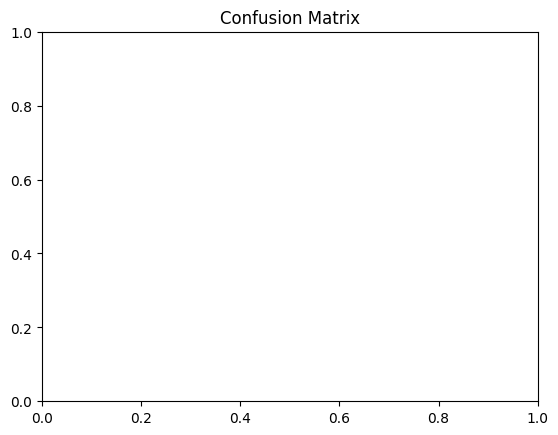

In [7]:
global_step = 0
best_mse = 1e5
num_epoch = 50 
phone_weight = 1.0
word_weight = 1.0
utterance_weight = 1.0

cur_lr = lr
for epoch in range(num_epoch):
    if epoch >= 10 and epoch % 3 == 0:
        cur_lr = (4 / 5) * cur_lr 
        for param_group in optimizer.param_groups:
            param_group['lr'] = cur_lr

    gopt_model.train()
    train_tqdm = tqdm(trainloader, "Training")
    for batch in train_tqdm:
        optimizer.zero_grad()

        ids, features, phone_ids, word_ids, relative_positions, \
            phone_labels, word_labels, utterance_labels, \
            fluency_labels, intonation_labels = to_device(batch, device)
        
        utterance_preds, phone_preds, word_preds, flu_preds, int_preds = gopt_model(
            x=features.float(), phn=phone_ids.long(), rel_pos=relative_positions.long())
                
        loss_phn, loss_utt, loss_word, loss_utt_flu, loss_utt_int = calculate_losses(
            phone_preds=phone_preds, 
            phone_labels=phone_labels, 
            word_preds=word_preds, 
            word_labels=word_labels, 
            utterance_preds=utterance_preds, 
            utterance_labels=utterance_labels,
            fluency_preds=flu_preds, 
            fluency_labels=fluency_labels,
            intonation_preds=int_preds,
            intonation_labels=intonation_labels
        )

        loss = phone_weight*loss_phn + word_weight*loss_word + utterance_weight*(loss_utt + loss_utt_flu + loss_utt_int)/3
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gopt_model.parameters(), 1.0)
        
        optimizer.step()
        
        global_step += 1
        train_tqdm.set_postfix(
            lr=cur_lr,
            loss=loss.item(), 
            loss_phn=loss_phn.item(), 
            loss_word=loss_word.item(), 
            loss_utt=loss_utt.item())
    
    valid_result = validate(
        epoch=epoch, 
        optimizer=optimizer,
        gopt_model=gopt_model, 
        testloader=testloader, 
        best_mse=best_mse, 
        ckpt_dir=ckpt_dir,
        device=device)
    
    best_mse = valid_result["best_mse"]
    global_step += 1